In [1]:
import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import math
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import random
import tqdm

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import matplotlib.pyplot as plt

class Island:
    def __init__(self, xcentr=5, ycentr=5, radius=1):
        self.xcentr = xcentr
        self.ycentr = ycentr
        self.radius = radius

    def belongs_to_boarder(self, x, y):
        dist = ((x - self.xcentr) ** 2 + (y - self.ycentr) ** 2) ** 0.5
        if dist <= self.radius:
            return True
        else:
            return False

    def get_dist(self, x, y):
        return ((x - self.xcentr) ** 2 + (y - self.ycentr) ** 2) ** 0.5 - self.radius

    def draw_island(self, color='blue'):
        return plt.Circle((self.xcentr, self.ycentr), self.radius, color=color)

    def getCoords(self):
        return [self.xcentr, self.ycentr]


In [3]:
class Target:
    def __init__(self, xcentr=5, ycentr=5, radius=1, angle=math.pi/2, vel=10):
        self.x = xcentr
        self.y = ycentr
        self.radius = radius
        self.direction = angle
        self.v = vel

    def belongs_to_boarder(self, x, y):
        dist = ((x - self.x) ** 2 + (y - self.y) ** 2) ** 0.5
        if dist <= self.radius:
            return True
        else:
            return False

    def get_dist(self, x, y):
        return ((x - self.x) ** 2 + (y - self.y) ** 2) ** 0.5 - self.radius

    def draw(self, color='blue'):
        return plt.Circle((self.x, self.y), self.radius, color=color)

    def getCoords(self):
        return [self.x, self.y]
    
    def move(self, dt=1):
        self.x += dt * self.v * math.cos(self.direction)
        self.y += dt * self.v * math.sin(self.direction)


In [4]:
x_lower_bound = 0
x_upper_bound = 10
y_lower_bound = 0
y_upper_bound = 10

a = {}

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
class Ship:
    def __init__(self, x = 1, y = 5, v = 1, direction = 0):
        self.x = x
        self.y = y
        self.v = v
        self.direction = direction
        self.prev_d = self.direction
        self.positions = [[self.x, self.y]]
        self.cum_d = 0
        
    def move(self, dt=1):
        self.x += dt * self.v * math.cos(self.direction)
        self.y += dt * self.v * math.sin(self.direction)
        self.cum_d += abs(self.direction - self.prev_d)
        self.prev_d = self.direction
        
    def getCoords(self):
        return [self.x, self.y]
    
    def add_position(self):
        self.positions.append([self.x, self.y])
        
    def get_positions(self):
        return self.positions

In [68]:
class Environment(object):
    def __init__(self):
        super(Environment, self).__init__()
        self.action_space = ['left', 'right', 'idle']
        self.n_actions = len(self.action_space)
        self.n_features = 2
        
        self.ship = None
        self.target = None
        self.flag = None

        self.build_environment()
        
        self.route = []
        self.list_of_route = []
        self.d = {}
        self.f = {}
        
        self.prev_dist = 0
        self.prev_i_dist = 0
        self.n_angles = 0

        self.i = 0

        self.c = True

        self.longest = 0

        self.shortest = 0
        
    def get_state(self):
        a = self.ship.getCoords()
        b = self.target.getCoords()
        c = self.flag.getCoords()
        dxi, dyi = b[0] - a[0], b[1] - a[1]
        dxf, dyf = c[0] - a[0], c[1] - a[1]
        f_angle = math.atan2(dyf, dxf)
        i_angle = math.atan2(dyi, dxi)
        return [f_angle - self.ship.direction, self.target.get_dist(a[0], a[1]), i_angle - self.ship.direction, self.flag.get_dist(a[0], a[1])]

    def build_environment(self):
        self.n_angles = 0
        rate = random.uniform(0.4, 0.6)
        dist = random.uniform(9, 15)
        angle = random.uniform(math.pi / 4, 3 * math.pi / 4)
        self.flag = Island(0, 0, 1)
        self.ship = Ship(-dist, 0)
        self.target = Target(-dist / 2 * math.cos(angle) - dist / 2, dist / 2 * math.sin(angle), 1, angle + math.pi, 1)
        self.ship.direction = 0
        self.prev_dist = self.flag.get_dist(self.ship.x, self.ship.y)
        self.prev_i_dist = self.target.get_dist(self.ship.x, self.ship.y)
    
    def reset(self):
        self.build_environment()
        self.d = {}
        self.i = 0
        return self.get_state()
    
    def step(self, action):
        dt = 1
        
        state = self.ship.getCoords()

        if action == 0:
            self.ship.direction += math.pi / 6
            self.n_angles += 1
        elif action == 1:
            self.ship.direction -= math.pi / 6
            self.n_angles += 1
        # elif action == 2:
        #     self.ship.v += 0.25
        # elif action == 3:
        #     self.ship.v -= 0.25
        
        self.ship.move(dt)
        self.target.move(dt)
        
        self.ship.add_position()

        next_state = self.get_state()

        self.i += 1
        
        if self.flag.belongs_to_boarder(self.ship.x, self.ship.y):
            reward = 20000
            done = True
            
            self.d = {}
            self.i = 0
            reward -= self.n_angles * 500

        elif self.target.belongs_to_boarder(self.ship.x, self.ship.y):
            reward = -10000
            done = True

            self.d = {}
            self.i = 0
            reward -= self.n_angles * 500
            
        elif len(self.ship.get_positions()) > 25:
            done = True
            self.d = {}
            self.i = 0
            # print("Time limit exceeded")
            reward = -1000 * (self.prev_dist - self.flag.get_dist(self.ship.x, self.ship.y)) ** 2
            reward -= self.n_angles * 500

        else:
            reward = (self.prev_dist - self.flag.get_dist(self.ship.x, self.ship.y)) ** 3
            reward -= 0.1 * (self.prev_i_dist - self.target.get_dist(self.ship.x, self.ship.y)) ** 3
            if reward < 0:
                reward *= 10
            # reward += 10 * (1 - self.ship.cum_d ** 2) * math.exp( - 0.5 * self.ship.cum_d ** 2) - 5
            done = False
        
        self.prev_dist = self.flag.get_dist(self.ship.x, self.ship.y)
        self.prev_i_dist = self.target.get_dist(self.ship.x, self.ship.y)
        # self.draw_map()
        return next_state, reward, done 
    
    def draw_map(self):
        field, ax = plt.subplots()
        ax.set(xlim=(x_upper_bound * -2, x_upper_bound * 2), ylim=(y_upper_bound * -2, y_upper_bound * 2))
        ax.set_aspect(1)
        ax.add_artist(self.target.draw('green'))
        ax.add_artist(self.flag.draw_island())
        pos = self.ship.get_positions()
        for i in range(len(pos) - 1):
            ax.plot([pos[i][0], pos[i + 1][0]], [pos[i][1], pos[i + 1][1]], marker = 'o', color='r')
        plt.show()

    def final(self):
        print('The shortest route:', self.shortest)
        print('The longest route:', self.longest)

def final_states():
    return a

if __name__ == '__main__':
    env = Environment()

Ключевая идея: подаем на вектор относительных координат острова и флага, а также пеленги на них.

In [69]:
BATCH_SIZE = 100
LR = 0.03
GAMMA = 0.90
EPSILON = 0.9
MEMORY_CAPACITY = 10000
Q_NETWORK_ITERATION = 1000

env = Environment()
NUM_ACTIONS = env.n_actions
NUM_STATES = 4
EPISODES = 200000

In [70]:
from torch.autograd import Variable 
class LSTM1(nn.Module):
    def __init__(self, num_classes=NUM_ACTIONS,
                 input_size=NUM_STATES,
                 hidden_size=NUM_STATES-2,
                 num_layers=2):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self, x):
        # h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        # c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out

In [71]:
class Net4(nn.Module):
    def __init__(self):
        super(Net4, self).__init__()
        self.fc1 = nn.Linear(NUM_STATES, 80)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(80, 160)
        self.fc2.weight.data.normal_(0, 0.1)
        self.fc3 = nn.Linear(160, 80)
        self.fc3.weight.data.normal_(0, 0.1)
        self.fc4 = nn.Linear(80, NUM_ACTIONS)
        self.fc4.weight.data.normal_(0, 0.1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        return x

In [72]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(NUM_STATES, 80)
        self.fc1.weight.data.normal_(0, 0.1)
        self.fc2 = nn.Linear(80, NUM_ACTIONS)
        self.fc2.weight.data.normal_(0, 0.1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [73]:
class DQN():
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()
        self.memory = np.zeros((MEMORY_CAPACITY, NUM_STATES * 2 + 2))
        self.memory_counter = 0
        self.learn_counter = 0
        self.optimizer = optim.Adam(self.eval_net.parameters(), LR)
        self.loss = nn.MSELoss()
        
    def store_trans(self, state, action, reward, next_state):
        index = self.memory_counter % MEMORY_CAPACITY
        trans = np.hstack((state, action, reward, next_state))
        self.memory[index, :] = trans
        self.memory_counter += 1
        
    def choose_action(self, state):
        state = torch.unsqueeze(torch.FloatTensor(state), 0)
        if np.random.randn() <= EPSILON:
            action_value = self.eval_net.forward(state)
            action = torch.max(action_value, 1)[1].data.numpy()
            action = action[0]
        else:
            action = np.random.randint(0, NUM_ACTIONS)
        return action
    
    def learn(self):
        # learn 100 times then the target network update
        if self.learn_counter % Q_NETWORK_ITERATION == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_counter+=1

        sample_index = np.random.choice(MEMORY_CAPACITY, BATCH_SIZE)
        batch_memory = self.memory[sample_index, :]
        batch_state = torch.FloatTensor(batch_memory[:, :NUM_STATES])
        #note that the action must be a int
        batch_action = torch.LongTensor(batch_memory[:, NUM_STATES:NUM_STATES+1].astype(int))
        batch_reward = torch.FloatTensor(batch_memory[:, NUM_STATES+1: NUM_STATES+2])
        batch_next_state = torch.FloatTensor(batch_memory[:, -NUM_STATES:])

        q_eval = self.eval_net(batch_state).gather(1, batch_action)
        q_next = self.target_net(batch_next_state).detach()
        q_target = batch_reward + GAMMA * q_next.max(1)[0].view(BATCH_SIZE, 1)

        loss = self.loss(q_eval, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

The DQN is collecting experience...


  0%|                                                                                       | 0/200000 [00:00<?, ?it/s]

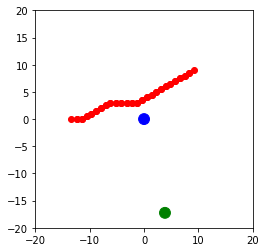

  0%|▍                                                                            | 998/200000 [00:08<56:41, 58.51it/s]

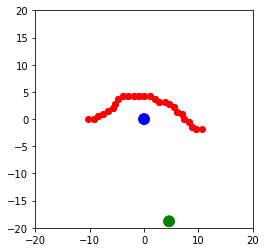

  1%|▊                                                                           | 1992/200000 [00:22<37:28, 88.06it/s]

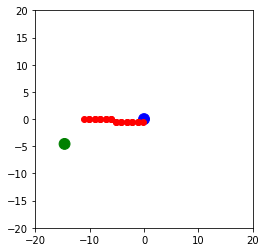

  1%|█                                                                          | 2995/200000 [00:32<32:25, 101.27it/s]

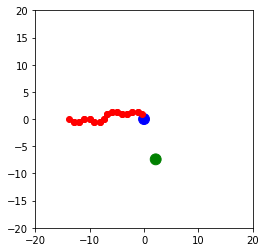

  2%|█▌                                                                          | 3992/200000 [00:42<34:42, 94.12it/s]

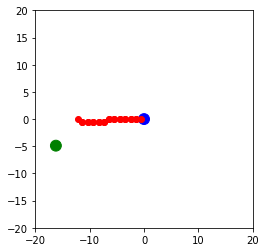

  2%|█▊                                                                         | 4996/200000 [00:52<31:41, 102.53it/s]

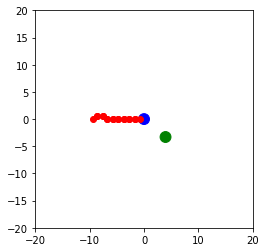

  3%|██▎                                                                         | 5995/200000 [01:02<37:06, 87.12it/s]

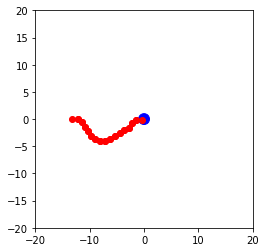

  3%|██▋                                                                         | 6993/200000 [01:12<32:12, 99.88it/s]

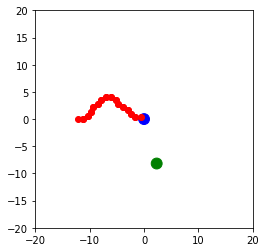

  4%|███                                                                         | 7997/200000 [01:22<33:38, 95.14it/s]

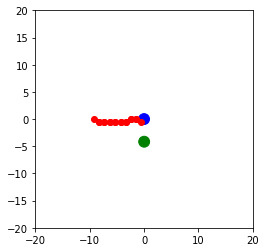

  4%|███▎                                                                       | 8996/200000 [01:33<30:24, 104.69it/s]

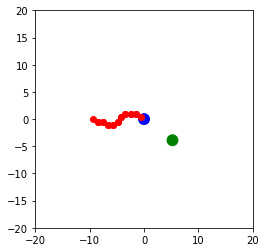

  5%|███▋                                                                       | 9990/200000 [01:43<30:26, 104.04it/s]

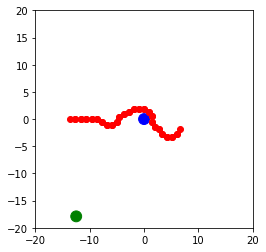

  5%|████                                                                       | 10993/200000 [01:53<33:40, 93.54it/s]

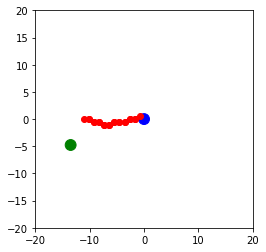

  6%|████▍                                                                      | 11994/200000 [02:04<32:49, 95.46it/s]

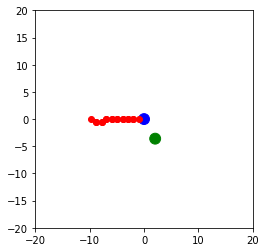

  6%|████▊                                                                      | 12994/200000 [02:14<32:18, 96.48it/s]

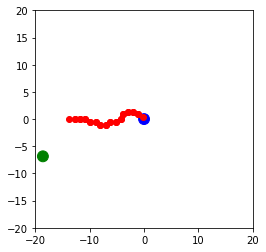

  7%|█████▏                                                                    | 13999/200000 [02:24<27:39, 112.11it/s]

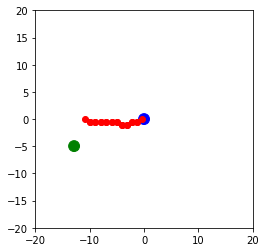

  7%|█████▌                                                                    | 14996/200000 [02:34<30:29, 101.10it/s]

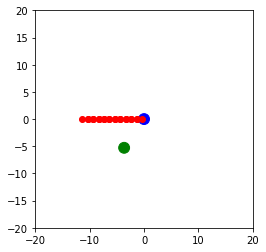

  8%|█████▉                                                                    | 15998/200000 [02:44<30:09, 101.67it/s]

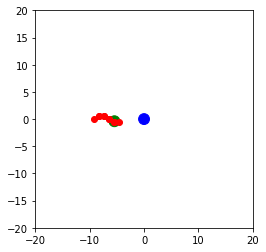

  8%|██████▎                                                                    | 16999/200000 [02:54<34:50, 87.53it/s]

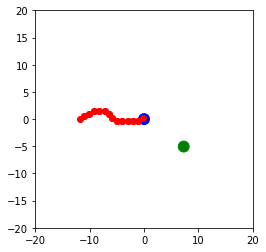

  9%|██████▋                                                                   | 18000/200000 [03:04<29:54, 101.43it/s]

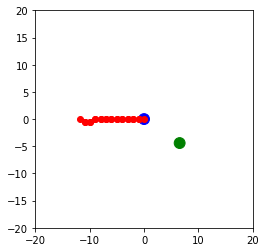

  9%|███████                                                                   | 18997/200000 [03:14<29:16, 103.05it/s]

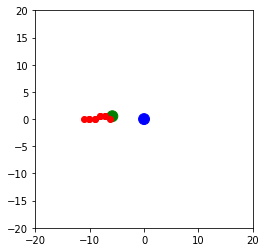

 10%|███████▌                                                                   | 20000/200000 [03:25<32:53, 91.21it/s]

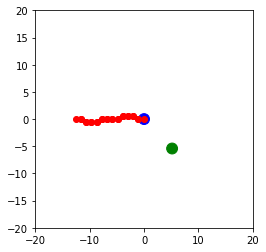

 10%|███████▊                                                                   | 20993/200000 [03:35<30:53, 96.57it/s]

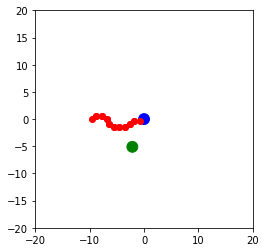

 11%|████████▏                                                                 | 21998/200000 [03:45<28:43, 103.27it/s]

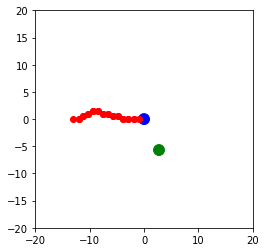

 11%|████████▌                                                                  | 22990/200000 [03:54<31:53, 92.52it/s]

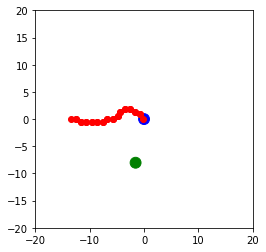

 12%|████████▉                                                                  | 23998/200000 [04:05<29:57, 97.89it/s]

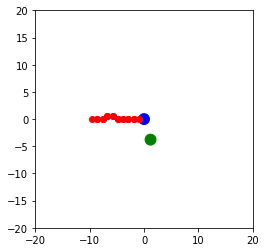

 12%|█████████▎                                                                 | 24992/200000 [04:15<34:10, 85.34it/s]

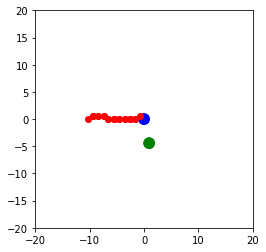

 13%|█████████▋                                                                 | 25992/200000 [04:26<29:05, 99.69it/s]

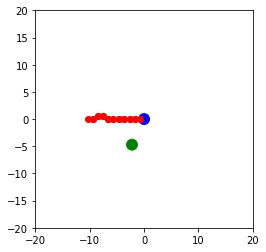

 13%|█████████▉                                                                | 26998/200000 [04:37<26:26, 109.04it/s]

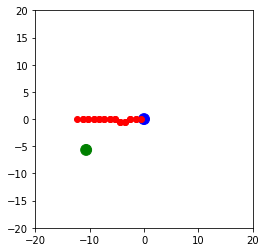

 14%|██████████▎                                                               | 27999/200000 [04:47<27:11, 105.41it/s]

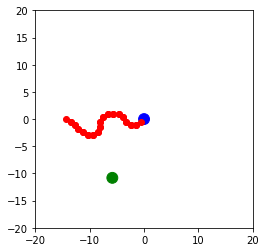

 14%|██████████▋                                                               | 28991/200000 [04:57<28:10, 101.18it/s]

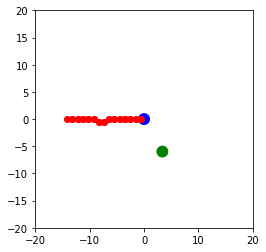

 15%|███████████▏                                                               | 29998/200000 [05:07<29:55, 94.66it/s]

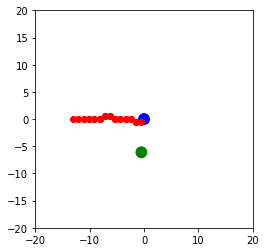

 16%|███████████▋                                                               | 31000/200000 [05:18<29:39, 94.95it/s]

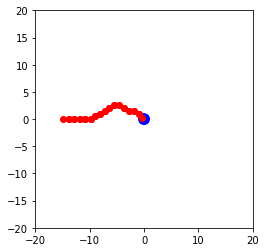

 16%|███████████▉                                                               | 31990/200000 [05:28<29:38, 94.47it/s]

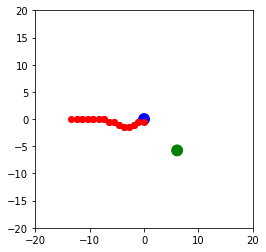

 16%|████████████▎                                                              | 32994/200000 [05:38<27:50, 99.96it/s]

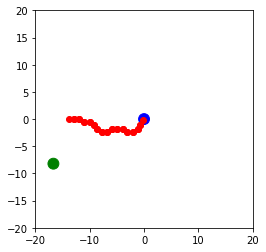

 17%|████████████▋                                                              | 33994/200000 [05:49<28:15, 97.91it/s]

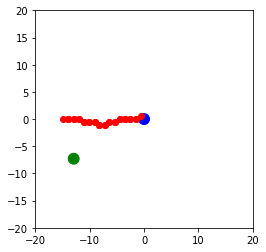

 17%|█████████████                                                              | 34991/200000 [06:00<29:38, 92.80it/s]

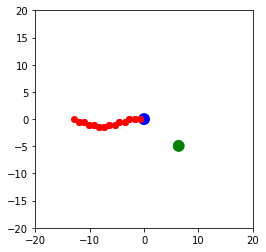

 18%|█████████████▍                                                             | 35995/200000 [06:11<28:30, 95.87it/s]

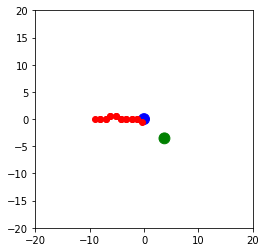

 18%|█████████████▉                                                             | 37000/200000 [06:22<28:36, 94.98it/s]

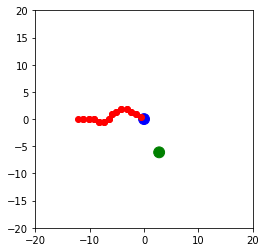

 19%|██████████████▏                                                            | 37999/200000 [06:33<28:19, 95.34it/s]

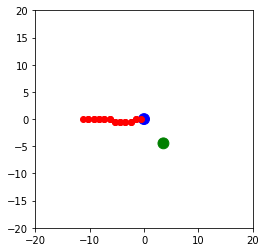

 19%|██████████████▌                                                            | 38992/200000 [06:44<29:23, 91.31it/s]

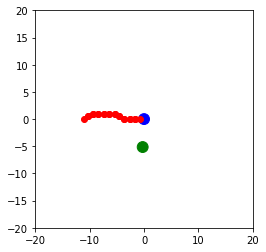

 20%|███████████████                                                            | 40000/200000 [06:56<30:11, 88.33it/s]

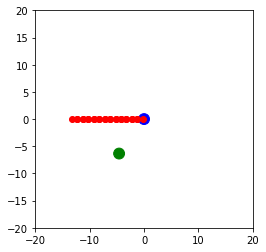

 20%|███████████████▎                                                           | 40993/200000 [07:07<29:09, 90.91it/s]

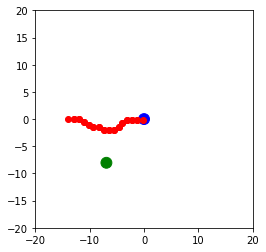

 21%|███████████████▋                                                           | 41998/200000 [07:18<29:34, 89.04it/s]

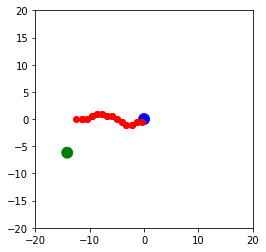

 21%|████████████████                                                           | 42997/200000 [07:29<32:09, 81.38it/s]

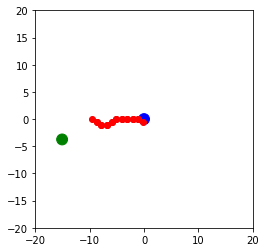

 22%|████████████████▍                                                          | 43999/200000 [07:40<28:15, 92.01it/s]

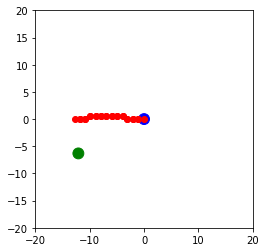

 22%|████████████████▊                                                          | 44998/200000 [07:52<30:20, 85.15it/s]

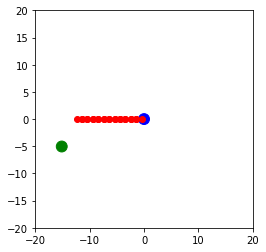

 23%|█████████████████▏                                                         | 45995/200000 [08:03<27:09, 94.50it/s]

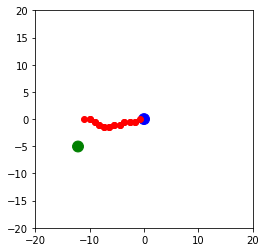

 23%|█████████████████▌                                                         | 46998/200000 [08:14<31:05, 82.00it/s]

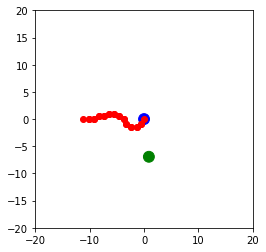

 24%|█████████████████▉                                                         | 47994/200000 [08:26<26:43, 94.81it/s]

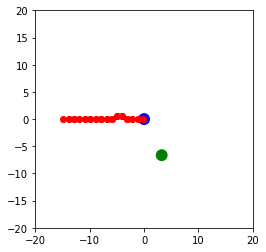

 24%|██████████████████▎                                                        | 48991/200000 [08:37<25:29, 98.72it/s]

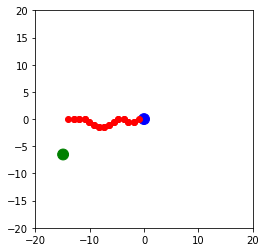

 25%|██████████████████▋                                                        | 49993/200000 [08:48<28:33, 87.54it/s]

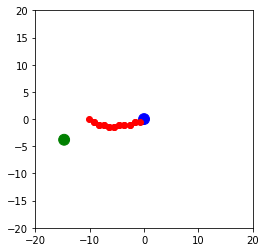

 26%|███████████████████▏                                                       | 51000/200000 [08:59<28:11, 88.08it/s]

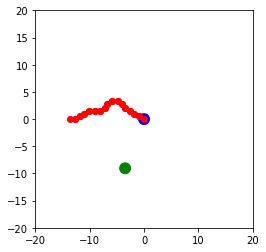

 26%|███████████████████▍                                                       | 51994/200000 [09:10<27:43, 88.98it/s]

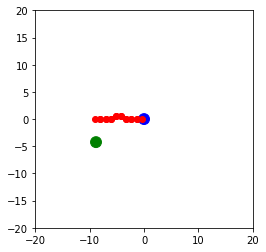

 26%|███████████████████▊                                                       | 52999/200000 [09:21<25:56, 94.44it/s]

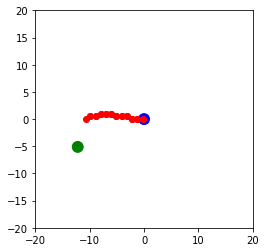

 27%|████████████████████▏                                                      | 53994/200000 [09:32<26:30, 91.77it/s]

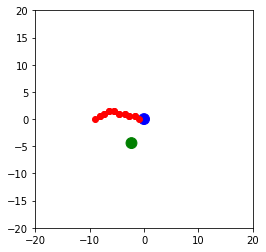

 27%|████████████████████▌                                                      | 54999/200000 [09:43<24:36, 98.19it/s]

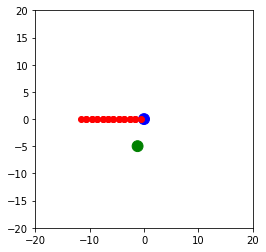

 28%|████████████████████▉                                                      | 55999/200000 [09:54<27:08, 88.42it/s]

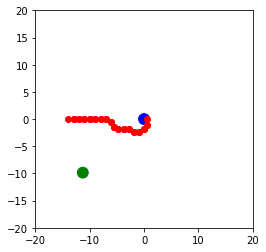

 28%|█████████████████████▎                                                     | 56997/200000 [10:06<28:07, 84.76it/s]

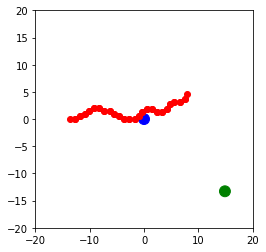

 29%|█████████████████████▋                                                     | 57994/200000 [10:17<25:39, 92.21it/s]

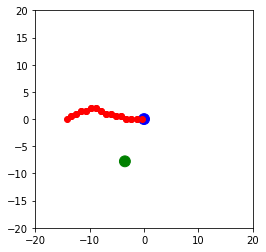

 29%|██████████████████████                                                     | 58994/200000 [10:29<26:41, 88.07it/s]

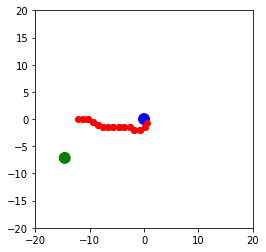

 30%|██████████████████████▍                                                    | 59992/200000 [10:40<27:07, 86.03it/s]

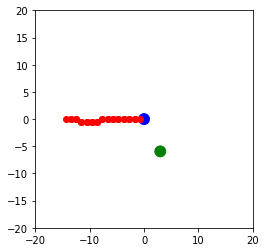

 30%|██████████████████████▊                                                    | 60994/200000 [10:51<25:16, 91.68it/s]

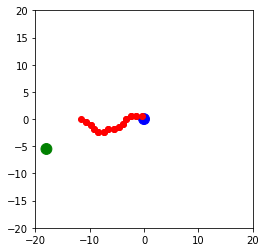

 31%|███████████████████████▏                                                   | 61993/200000 [11:03<27:01, 85.12it/s]

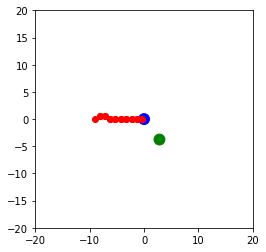

 31%|███████████████████████▌                                                   | 62992/200000 [11:14<26:16, 86.91it/s]

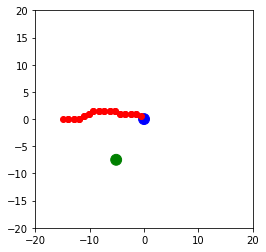

 32%|████████████████████████                                                   | 64000/200000 [11:26<25:20, 89.44it/s]

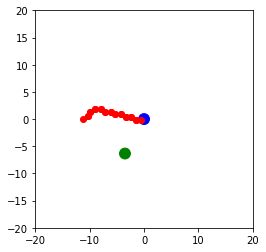

 32%|████████████████████████▎                                                  | 64991/200000 [11:37<25:53, 86.90it/s]

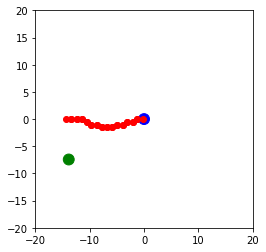

 33%|████████████████████████▋                                                  | 65992/200000 [11:49<23:57, 93.21it/s]

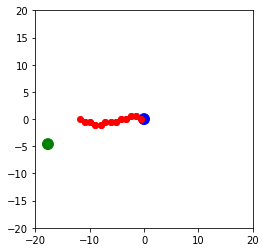

 33%|█████████████████████████                                                  | 66996/200000 [12:01<26:35, 83.36it/s]

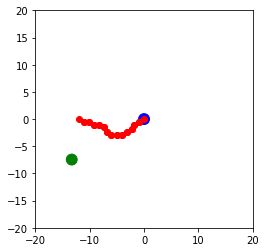

 34%|█████████████████████████▍                                                 | 67995/200000 [12:12<22:11, 99.13it/s]

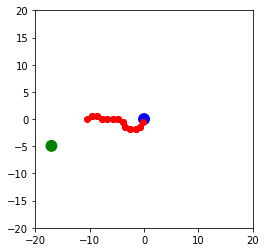

 34%|█████████████████████████▊                                                 | 68996/200000 [12:23<23:29, 92.97it/s]

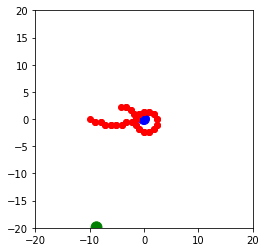

 35%|██████████████████████████▎                                                | 70000/200000 [12:35<24:24, 88.77it/s]

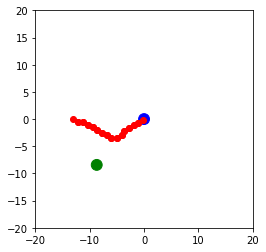

 35%|██████████████████████████▌                                                | 70994/200000 [12:46<25:31, 84.25it/s]

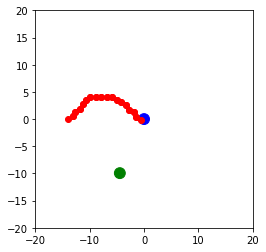

 36%|██████████████████████████▉                                                | 71998/200000 [12:57<24:02, 88.73it/s]

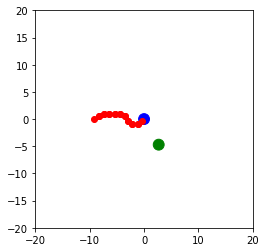

 36%|███████████████████████████▎                                               | 72998/200000 [13:09<24:05, 87.86it/s]

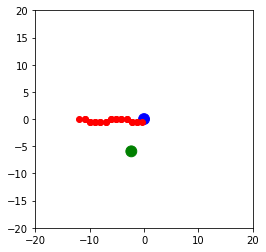

 37%|███████████████████████████▋                                               | 73998/200000 [13:21<25:06, 83.63it/s]

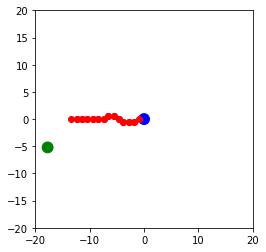

 37%|████████████████████████████                                               | 74994/200000 [13:32<24:06, 86.43it/s]

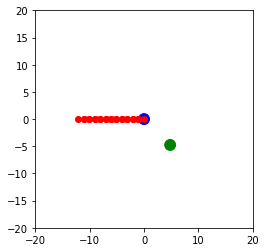

 38%|████████████████████████████▍                                              | 75998/200000 [13:44<23:28, 88.02it/s]

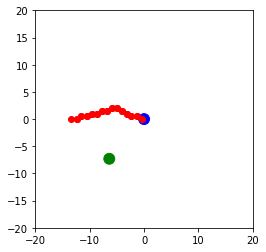

 38%|████████████████████████████▊                                              | 76991/200000 [13:55<23:24, 87.60it/s]

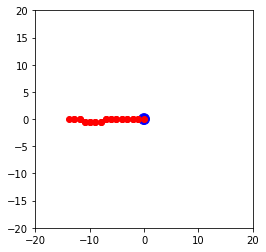

 39%|█████████████████████████████▏                                             | 77993/200000 [14:07<22:20, 91.04it/s]

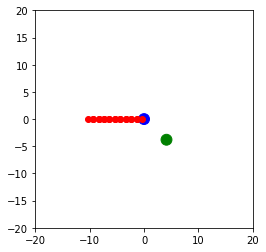

 39%|█████████████████████████████▌                                             | 78991/200000 [14:18<21:28, 93.93it/s]

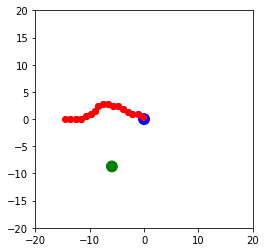

 40%|█████████████████████████████▉                                             | 79992/200000 [14:29<24:15, 82.42it/s]

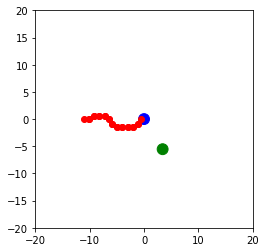

 40%|██████████████████████████████▍                                            | 81000/200000 [14:41<21:39, 91.58it/s]

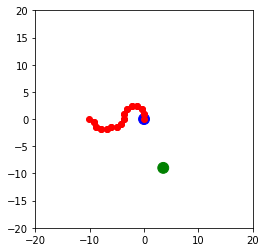

 41%|██████████████████████████████▋                                            | 81999/200000 [14:52<23:43, 82.89it/s]

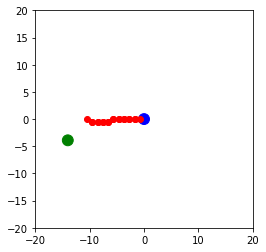

 41%|███████████████████████████████                                            | 82999/200000 [15:04<23:47, 81.96it/s]

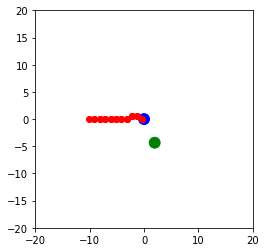

 42%|███████████████████████████████▌                                           | 84000/200000 [15:15<21:45, 88.86it/s]

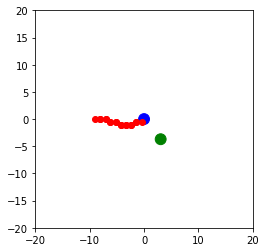

 42%|███████████████████████████████▊                                           | 84991/200000 [15:27<22:29, 85.23it/s]

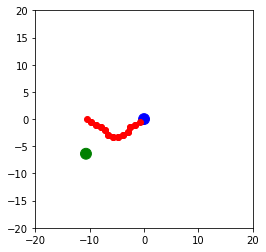

 43%|████████████████████████████████▏                                          | 85996/200000 [15:38<21:51, 86.91it/s]

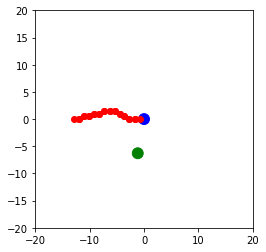

 43%|████████████████████████████████▌                                          | 86991/200000 [15:50<21:44, 86.61it/s]

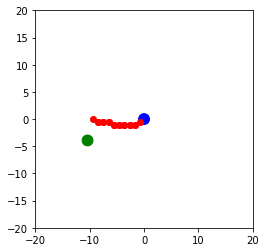

 44%|████████████████████████████████▉                                          | 87993/200000 [16:01<21:23, 87.25it/s]

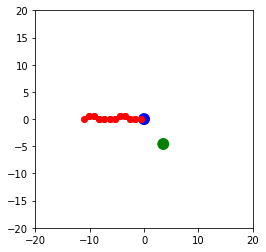

 44%|█████████████████████████████████▎                                         | 88997/200000 [16:13<20:50, 88.77it/s]

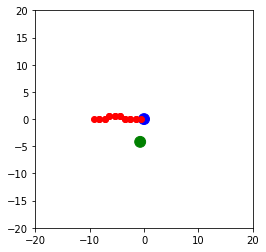

 45%|█████████████████████████████████▋                                         | 89998/200000 [16:24<21:18, 86.05it/s]

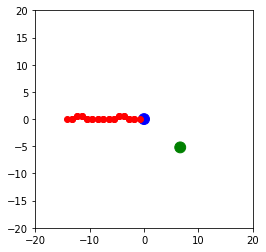

 45%|██████████████████████████████████                                         | 90996/200000 [16:36<19:59, 90.90it/s]

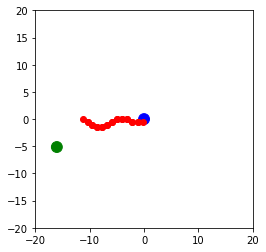

 46%|██████████████████████████████████▍                                        | 91996/200000 [16:47<20:48, 86.52it/s]

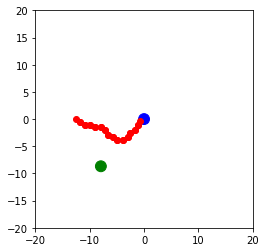

 46%|██████████████████████████████████▊                                        | 92995/200000 [16:59<19:36, 90.96it/s]

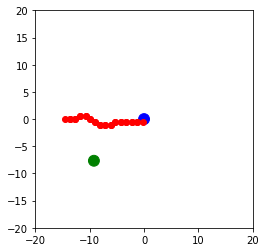

 47%|███████████████████████████████████▏                                       | 93995/200000 [17:10<19:38, 89.92it/s]

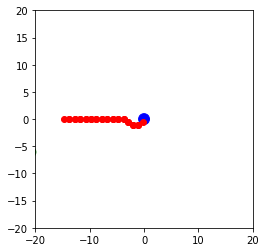

 47%|███████████████████████████████████▌                                       | 94992/200000 [17:21<18:37, 93.96it/s]

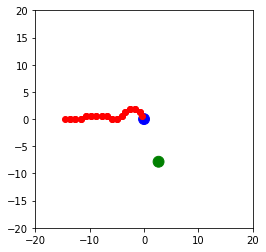

 48%|███████████████████████████████████▉                                       | 95992/200000 [17:33<21:26, 80.85it/s]

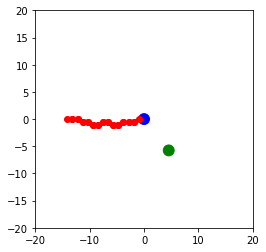

 48%|████████████████████████████████████▎                                      | 96997/200000 [17:44<20:13, 84.89it/s]

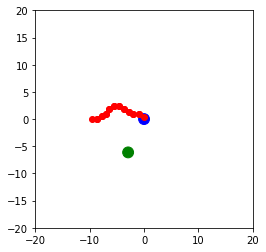

 49%|████████████████████████████████████▋                                      | 97995/200000 [17:56<20:49, 81.62it/s]

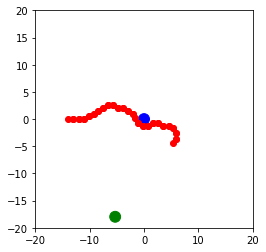

 49%|█████████████████████████████████████                                      | 98992/200000 [18:08<19:11, 87.71it/s]

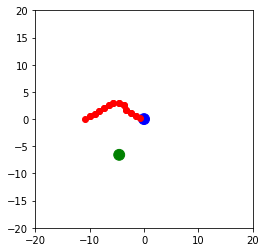

 50%|█████████████████████████████████████▍                                     | 99993/200000 [18:19<19:41, 84.65it/s]

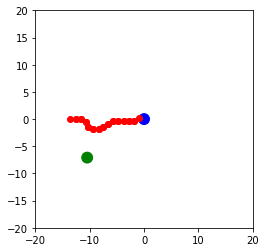

 50%|█████████████████████████████████████▎                                    | 100999/200000 [18:31<18:13, 90.55it/s]

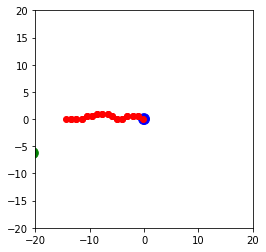

 51%|█████████████████████████████████████▋                                    | 101993/200000 [18:42<17:59, 90.79it/s]

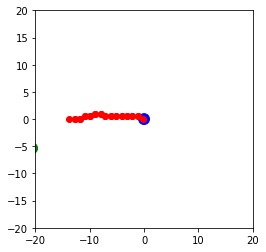

 51%|██████████████████████████████████████                                    | 102994/200000 [18:54<18:02, 89.59it/s]

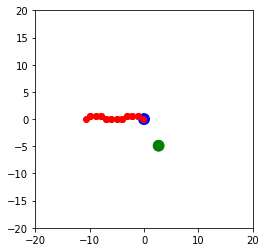

 52%|██████████████████████████████████████▍                                   | 103999/200000 [19:06<16:42, 95.74it/s]

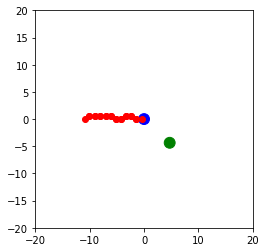

 52%|██████████████████████████████████████▊                                   | 104998/200000 [19:17<17:36, 89.94it/s]

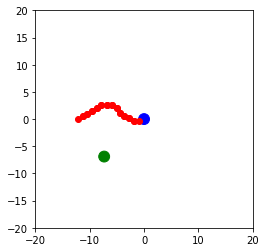

 53%|███████████████████████████████████████▏                                  | 105993/200000 [19:29<17:47, 88.09it/s]

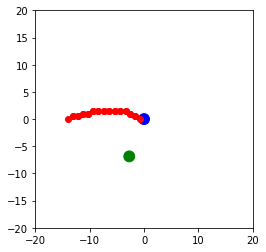

 53%|███████████████████████████████████████▌                                  | 106999/200000 [19:40<18:25, 84.10it/s]

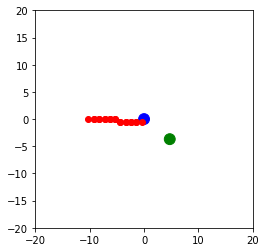

 54%|███████████████████████████████████████▉                                  | 107994/200000 [19:52<18:16, 83.88it/s]

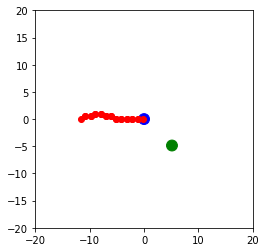

 54%|████████████████████████████████████████▎                                 | 108994/200000 [20:04<17:33, 86.41it/s]

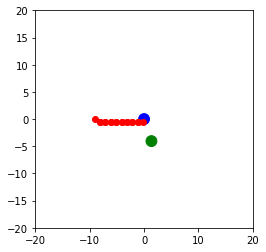

 55%|████████████████████████████████████████▋                                 | 110000/200000 [20:16<18:01, 83.22it/s]

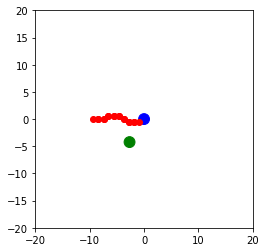

 56%|█████████████████████████████████████████                                 | 111000/200000 [20:27<17:14, 85.99it/s]

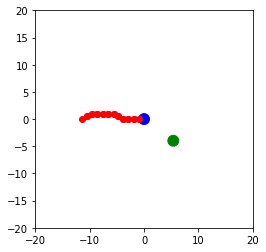

 56%|█████████████████████████████████████████▍                                | 111992/200000 [20:39<17:14, 85.11it/s]

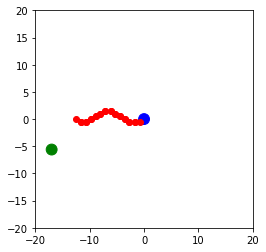

 56%|█████████████████████████████████████████▊                                | 112997/200000 [20:51<16:36, 87.33it/s]

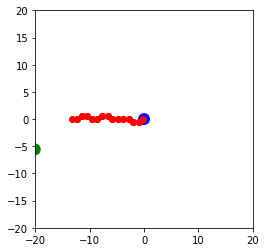

 57%|██████████████████████████████████████████▏                               | 113998/200000 [21:02<16:18, 87.87it/s]

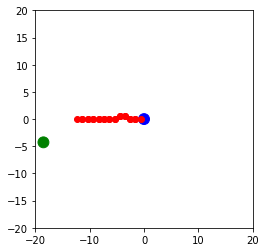

 57%|██████████████████████████████████████████▌                               | 114995/200000 [21:14<16:40, 84.93it/s]

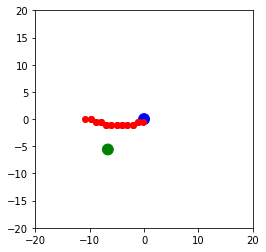

 58%|██████████████████████████████████████████▉                               | 115998/200000 [21:26<15:10, 92.27it/s]

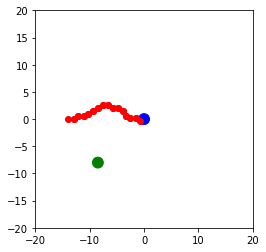

 58%|███████████████████████████████████████████▎                              | 116993/200000 [21:37<15:30, 89.22it/s]

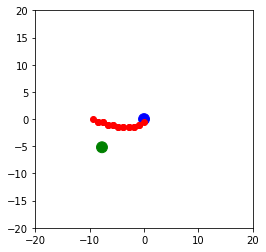

 59%|███████████████████████████████████████████▋                              | 117996/200000 [21:49<14:48, 92.27it/s]

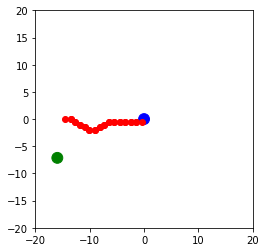

 59%|████████████████████████████████████████████                              | 118994/200000 [22:01<15:01, 89.82it/s]

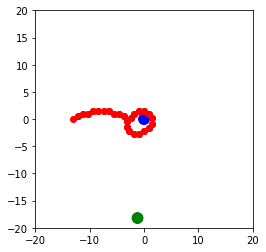

 60%|████████████████████████████████████████████▍                             | 119998/200000 [22:12<14:48, 89.99it/s]

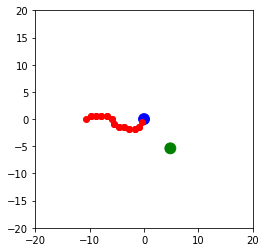

 60%|████████████████████████████████████████████▊                             | 120994/200000 [22:24<13:32, 97.27it/s]

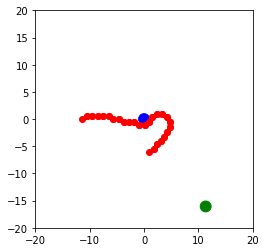

 61%|█████████████████████████████████████████████▏                            | 121995/200000 [22:35<13:21, 97.37it/s]

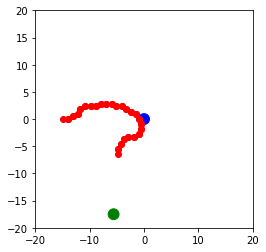

 61%|█████████████████████████████████████████████▌                            | 122996/200000 [22:47<14:27, 88.74it/s]

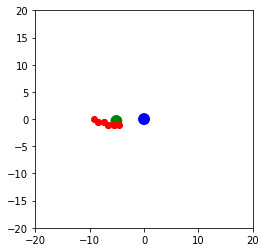

 62%|█████████████████████████████████████████████▉                            | 123994/200000 [22:59<15:21, 82.52it/s]

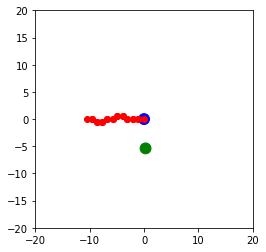

 62%|██████████████████████████████████████████████▏                           | 124998/200000 [23:11<14:29, 86.22it/s]

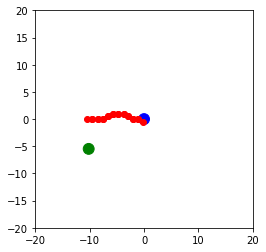

 63%|██████████████████████████████████████████████▌                           | 125996/200000 [23:22<15:24, 80.06it/s]

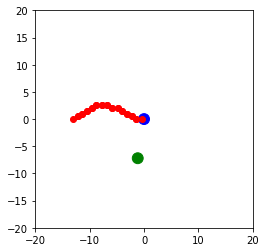

 63%|██████████████████████████████████████████████▉                           | 126994/200000 [23:34<13:38, 89.19it/s]

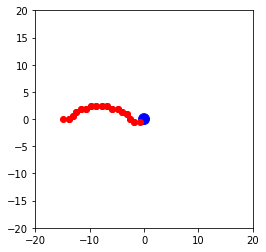

 64%|███████████████████████████████████████████████▎                          | 127996/200000 [23:46<13:15, 90.47it/s]

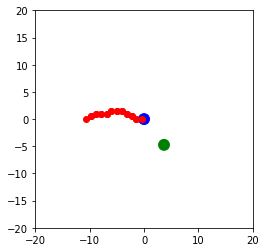

 64%|███████████████████████████████████████████████▋                          | 128999/200000 [23:57<13:07, 90.11it/s]

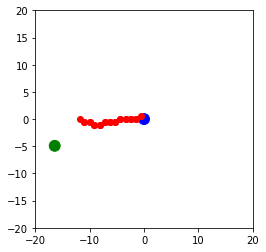

 65%|████████████████████████████████████████████████                          | 129995/200000 [24:09<13:18, 87.68it/s]

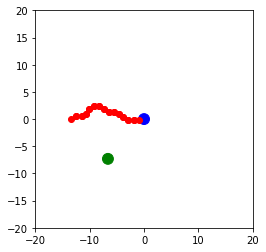

 65%|████████████████████████████████████████████████▍                         | 130999/200000 [24:21<13:28, 85.40it/s]

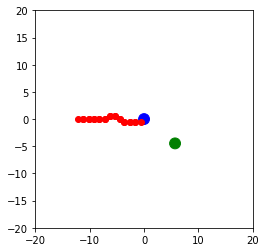

 66%|████████████████████████████████████████████████▊                         | 131992/200000 [24:32<12:59, 87.26it/s]

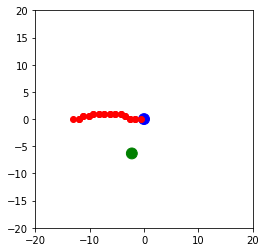

 66%|█████████████████████████████████████████████████▏                        | 132998/200000 [24:44<13:11, 84.67it/s]

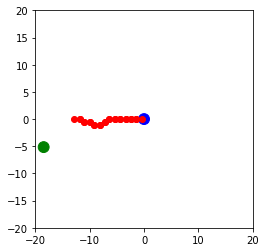

 67%|█████████████████████████████████████████████████▌                        | 133994/200000 [24:56<13:01, 84.50it/s]

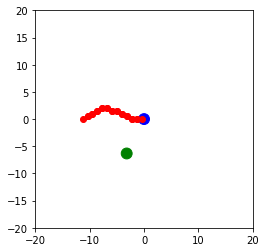

 67%|█████████████████████████████████████████████████▉                        | 134991/200000 [25:07<12:04, 89.77it/s]

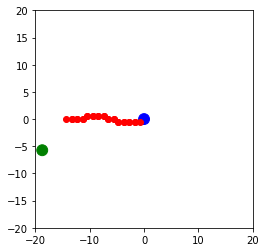

 68%|██████████████████████████████████████████████████▎                       | 135996/200000 [25:19<12:17, 86.82it/s]

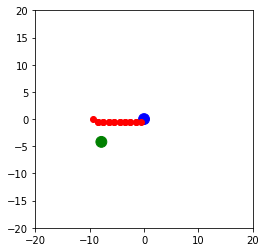

 68%|██████████████████████████████████████████████████▋                       | 136993/200000 [25:30<11:44, 89.38it/s]

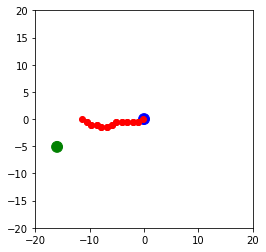

 69%|███████████████████████████████████████████████████                       | 137994/200000 [25:42<12:38, 81.80it/s]

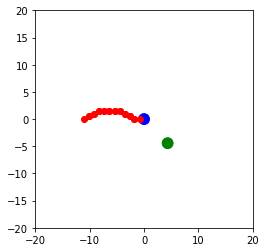

 69%|███████████████████████████████████████████████████▍                      | 138997/200000 [25:54<12:15, 82.93it/s]

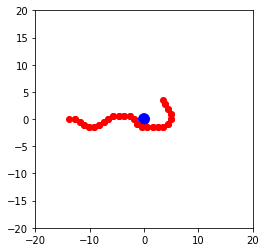

 70%|███████████████████████████████████████████████████▊                      | 139996/200000 [26:06<10:48, 92.54it/s]

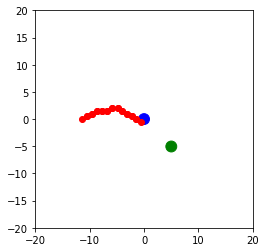

 70%|████████████████████████████████████████████████████▏                     | 140996/200000 [26:18<10:53, 90.24it/s]

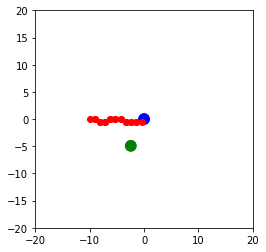

 71%|████████████████████████████████████████████████████▌                     | 142000/200000 [26:30<11:05, 87.21it/s]

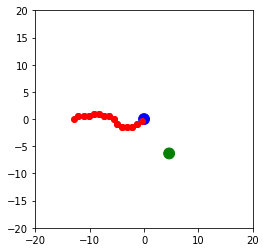

 71%|████████████████████████████████████████████████████▉                     | 142993/200000 [26:41<10:31, 90.30it/s]

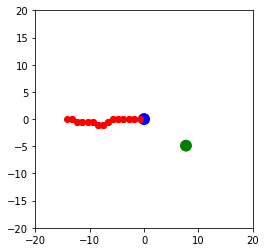

 72%|█████████████████████████████████████████████████████▎                    | 143993/200000 [26:53<10:37, 87.87it/s]

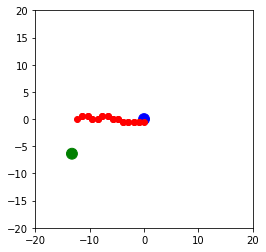

 72%|█████████████████████████████████████████████████████▋                    | 144996/200000 [27:05<10:45, 85.25it/s]

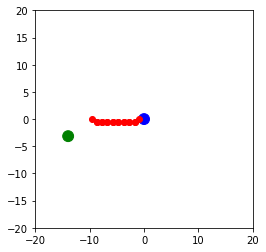

 73%|██████████████████████████████████████████████████████                    | 145997/200000 [27:17<11:40, 77.11it/s]

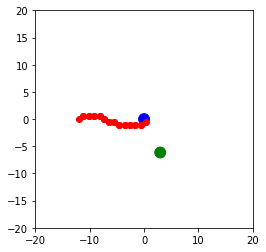

 73%|██████████████████████████████████████████████████████▍                   | 146996/200000 [27:28<09:59, 88.37it/s]

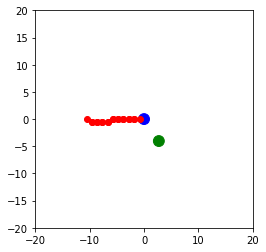

 74%|██████████████████████████████████████████████████████▊                   | 147998/200000 [27:40<10:25, 83.09it/s]

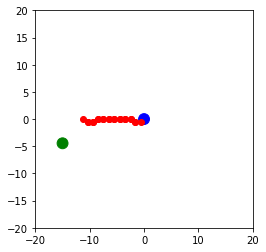

 74%|███████████████████████████████████████████████████████▏                  | 148996/200000 [27:52<09:39, 88.09it/s]

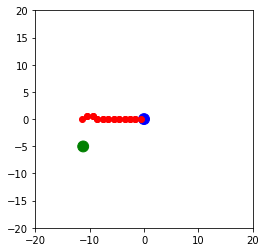

 75%|███████████████████████████████████████████████████████▍                  | 149998/200000 [28:04<09:49, 84.86it/s]

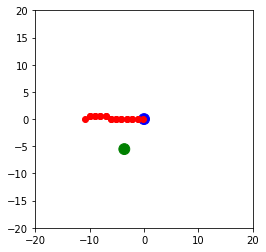

 75%|███████████████████████████████████████████████████████▊                  | 150999/200000 [28:15<09:37, 84.89it/s]

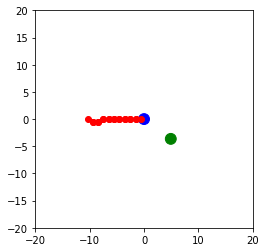

 76%|████████████████████████████████████████████████████████▏                 | 151999/200000 [28:27<09:18, 85.98it/s]

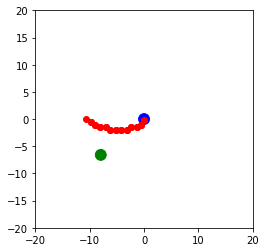

 76%|████████████████████████████████████████████████████████▌                 | 152997/200000 [28:39<09:20, 83.86it/s]

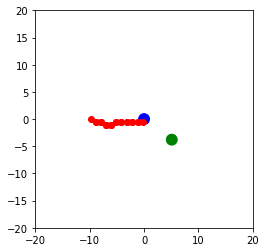

 77%|████████████████████████████████████████████████████████▉                 | 153998/200000 [28:51<09:15, 82.89it/s]

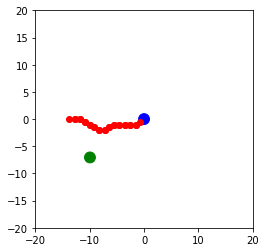

 77%|█████████████████████████████████████████████████████████▎                | 154994/200000 [29:02<08:36, 87.21it/s]

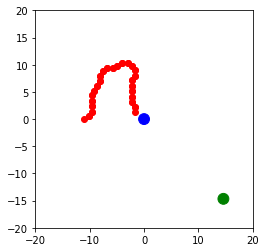

 78%|█████████████████████████████████████████████████████████▋                | 156000/200000 [29:14<07:46, 94.40it/s]

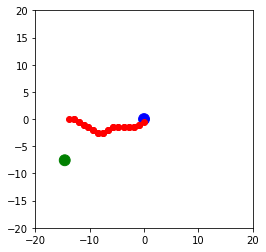

 78%|██████████████████████████████████████████████████████████                | 156997/200000 [29:26<08:16, 86.68it/s]

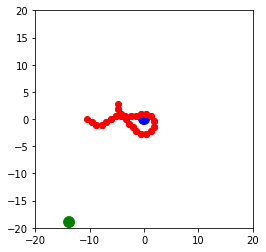

 79%|██████████████████████████████████████████████████████████▍               | 157991/200000 [29:38<07:49, 89.54it/s]

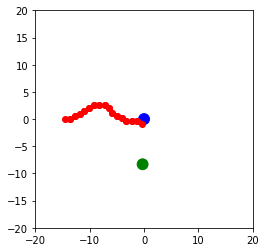

 79%|██████████████████████████████████████████████████████████▊               | 158994/200000 [29:50<08:08, 84.00it/s]

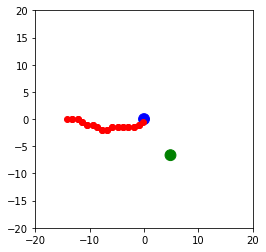

 80%|███████████████████████████████████████████████████████████▏              | 159998/200000 [30:02<07:41, 86.76it/s]

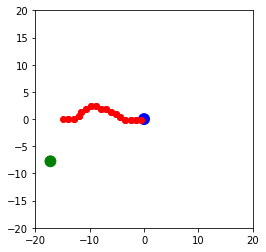

 80%|███████████████████████████████████████████████████████████▌              | 160997/200000 [30:14<07:06, 91.44it/s]

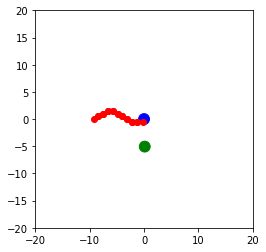

 81%|███████████████████████████████████████████████████████████▉              | 161999/200000 [30:26<07:07, 88.92it/s]

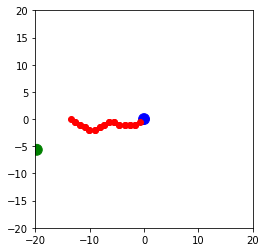

 81%|████████████████████████████████████████████████████████████▎             | 162994/200000 [30:38<07:09, 86.16it/s]

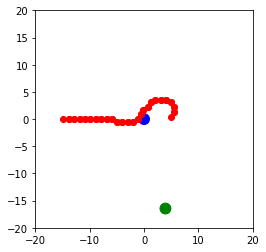

 82%|████████████████████████████████████████████████████████████▋             | 163995/200000 [30:50<07:01, 85.51it/s]

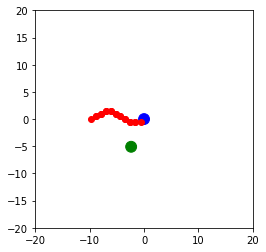

 82%|█████████████████████████████████████████████████████████████             | 164992/200000 [31:01<06:28, 90.19it/s]

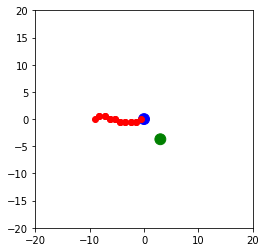

 83%|█████████████████████████████████████████████████████████████▍            | 165997/200000 [31:13<06:53, 82.21it/s]

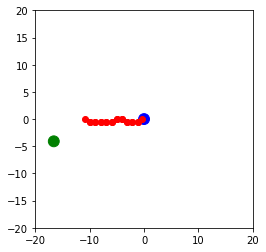

 84%|█████████████████████████████████████████████████████████████▊            | 167000/200000 [31:25<06:09, 89.38it/s]

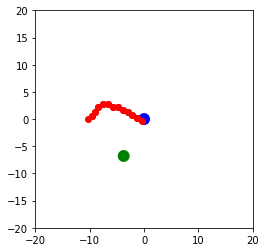

 84%|██████████████████████████████████████████████████████████████▏           | 167995/200000 [31:37<06:16, 84.93it/s]

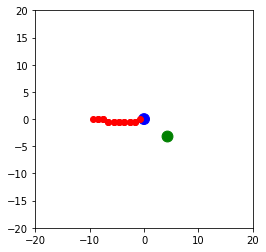

 84%|██████████████████████████████████████████████████████████████▌           | 169000/200000 [31:49<06:07, 84.24it/s]

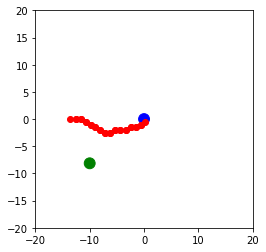

 85%|██████████████████████████████████████████████████████████████▉           | 169993/200000 [32:01<06:15, 80.00it/s]

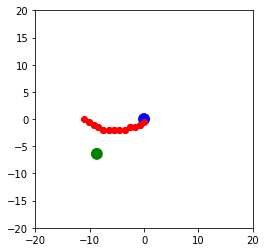

 85%|███████████████████████████████████████████████████████████████▎          | 170999/200000 [32:13<05:47, 83.57it/s]

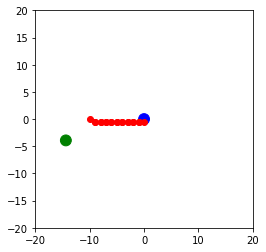

 86%|███████████████████████████████████████████████████████████████▋          | 171991/200000 [32:24<05:56, 78.66it/s]

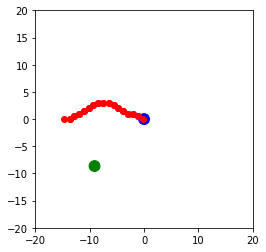

 86%|████████████████████████████████████████████████████████████████          | 172993/200000 [32:36<05:13, 86.27it/s]

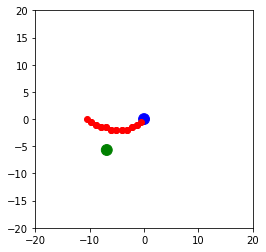

 87%|████████████████████████████████████████████████████████████████▍         | 173997/200000 [32:47<05:07, 84.58it/s]

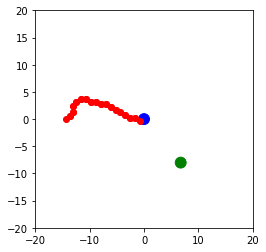

 88%|████████████████████████████████████████████████████████████████▊         | 175000/200000 [32:59<04:58, 83.88it/s]

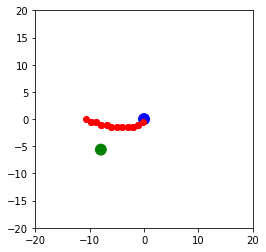

 88%|█████████████████████████████████████████████████████████████████         | 176000/200000 [33:11<04:37, 86.61it/s]

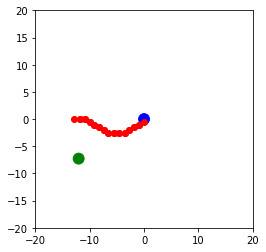

 88%|█████████████████████████████████████████████████████████████████▍        | 176993/200000 [33:23<04:21, 87.94it/s]

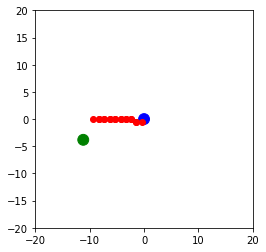

 89%|█████████████████████████████████████████████████████████████████▊        | 177997/200000 [33:35<04:34, 80.10it/s]

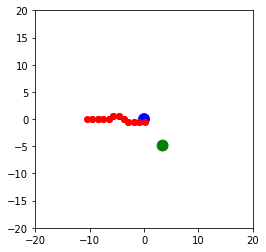

 89%|██████████████████████████████████████████████████████████████████▏       | 178998/200000 [33:47<04:05, 85.42it/s]

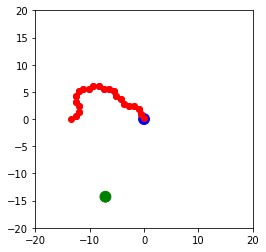

 90%|██████████████████████████████████████████████████████████████████▌       | 179999/200000 [33:59<04:07, 80.80it/s]

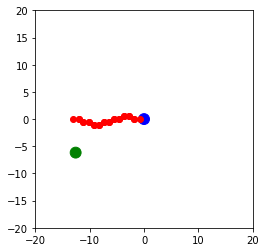

 90%|██████████████████████████████████████████████████████████████████▉       | 180999/200000 [34:10<03:36, 87.65it/s]

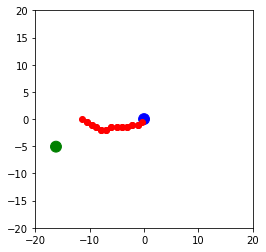

 91%|███████████████████████████████████████████████████████████████████▎      | 181995/200000 [34:23<03:27, 86.60it/s]

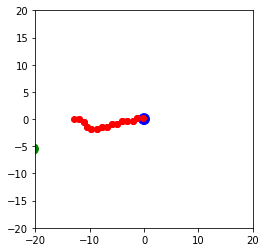

 91%|███████████████████████████████████████████████████████████████████▋      | 182994/200000 [34:34<03:07, 90.55it/s]

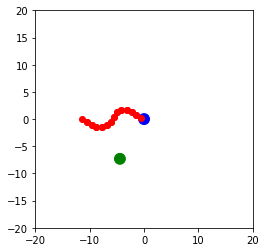

 92%|████████████████████████████████████████████████████████████████████      | 183998/200000 [34:46<02:59, 89.11it/s]

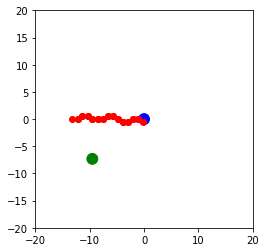

 92%|████████████████████████████████████████████████████████████████████▍     | 184992/200000 [34:58<02:47, 89.44it/s]

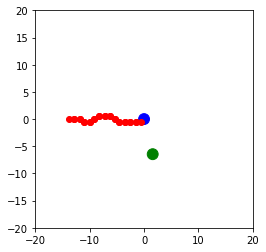

 93%|████████████████████████████████████████████████████████████████████▊     | 185998/200000 [35:10<02:53, 80.53it/s]

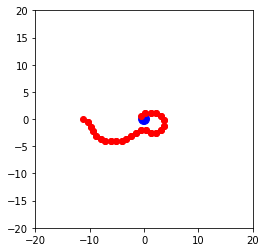

 93%|█████████████████████████████████████████████████████████████████████▏    | 186995/200000 [35:21<02:42, 80.06it/s]

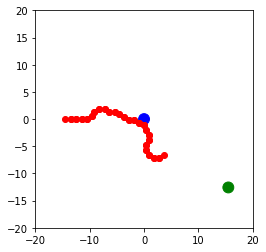

 94%|█████████████████████████████████████████████████████████████████████▌    | 187996/200000 [35:34<02:25, 82.57it/s]

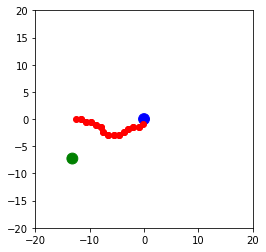

 94%|█████████████████████████████████████████████████████████████████████▉    | 189000/200000 [35:45<02:12, 82.90it/s]

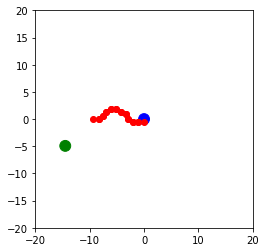

 95%|██████████████████████████████████████████████████████████████████████▎   | 190000/200000 [35:57<01:51, 89.71it/s]

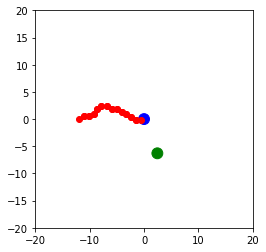

 95%|██████████████████████████████████████████████████████████████████████▋   | 190998/200000 [36:09<01:45, 85.09it/s]

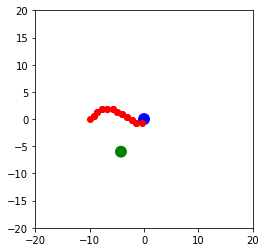

 96%|███████████████████████████████████████████████████████████████████████   | 191998/200000 [36:21<01:32, 86.36it/s]

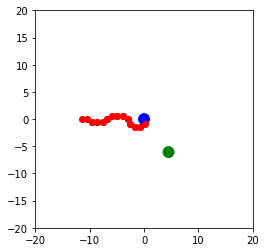

 96%|███████████████████████████████████████████████████████████████████████▍  | 192994/200000 [36:33<01:21, 85.66it/s]

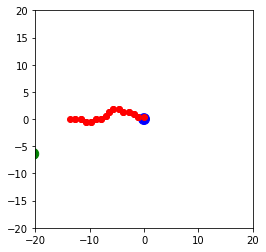

 97%|███████████████████████████████████████████████████████████████████████▊  | 193998/200000 [36:44<01:06, 90.18it/s]

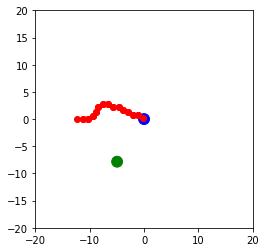

 97%|████████████████████████████████████████████████████████████████████████▏ | 194994/200000 [36:56<01:02, 80.58it/s]

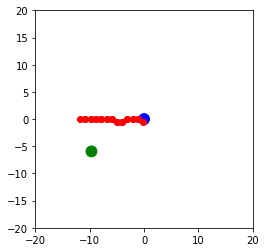

 98%|████████████████████████████████████████████████████████████████████████▌ | 195996/200000 [37:08<00:45, 87.56it/s]

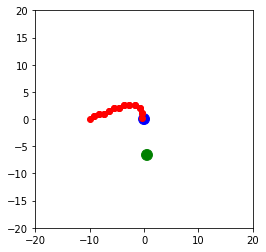

 98%|████████████████████████████████████████████████████████████████████████▉ | 196998/200000 [37:20<00:35, 85.21it/s]

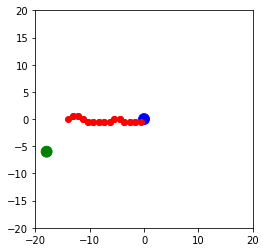

 99%|█████████████████████████████████████████████████████████████████████████▎| 198000/200000 [37:31<00:24, 82.36it/s]

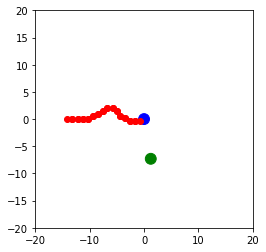

 99%|█████████████████████████████████████████████████████████████████████████▋| 198996/200000 [37:43<00:12, 80.51it/s]

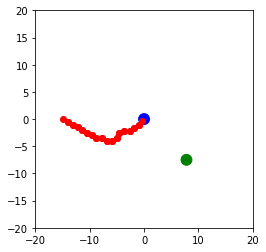

100%|██████████████████████████████████████████████████████████████████████████| 200000/200000 [37:55<00:00, 87.89it/s]


In [74]:
rewards = []
net = DQN()

def main():
    print("The DQN is collecting experience...")
    step_counter_list = []
    for episode in tqdm.tqdm(range(EPISODES)):
        state = env.reset()
        step_counter = 0
        sum_rew = 0
        while True:
            step_counter +=1
            action = net.choose_action(state)
            next_state, reward, done = env.step(action)
            # reward = reward * 100 if reward > 0 else reward * 5
            sum_rew += reward
            net.store_trans(state, action, reward, next_state)
            if net.memory_counter >= MEMORY_CAPACITY:
                net.learn()
            if done:
                step_counter_list.append(step_counter)
                # print("episode {}, the reward is {}".format(episode, round(reward, 3)))
                rewards.append(sum_rew)
                if episode % 1000 == 0:
                    env.draw_map()
                # net.plot(net.ax, step_counter_list)
                break

            state = next_state
            

if __name__ == '__main__':
    main()

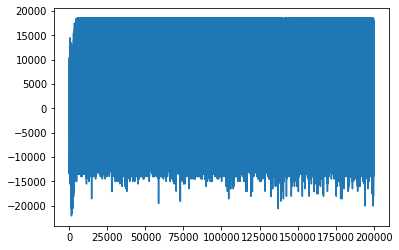

In [22]:
plt.plot(rewards)

In [23]:
m = 0
p = 0
for i in rewards:
    if i < 0:
        m += 1
    else:
        p += 1

In [24]:
m / (m + p)

0.410965

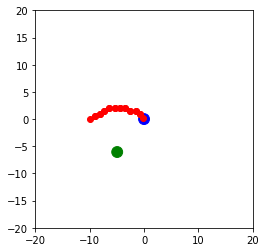

In [25]:
env.draw_map()

In [ ]:
class QLearningTable:
    def __init__(self, actions, learning_rate=0.01, reward_decay=0.9, e_greedy=0.9):
        self.actions = actions
        print(self.actions)
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon = e_greedy
        self.q_table = pd.DataFrame(columns=self.actions, dtype=np.float64)
        self.q_table_final = pd.DataFrame(columns=self.actions, dtype=np.float64)

    def choose_action(self, observation):
        self.check_state_exist(observation)
        
        if np.random.uniform() < self.epsilon:
            state_action = self.q_table.loc[observation, :]
            state_action = state_action.reindex(np.random.permutation(state_action.index))
            action = state_action.idxmax()
        else:
            action = np.random.choice(self.actions)
        return action

    def learn(self, state, action, reward, next_state):
        self.check_state_exist(next_state)

        q_predict = self.q_table.loc[state, action]

        if next_state != 'goal' or next_state != 'obstacle':
            q_target = reward + self.gamma * self.q_table.loc[next_state, :].max()
        else:
            q_target = reward
        self.q_table.loc[state, action] += self.lr * (q_target - q_predict)

        return self.q_table.loc[state, action]

    def check_state_exist(self, state):
        if state not in self.q_table.index:
            self.q_table = self.q_table.append(
                pd.Series(
                    [0]*len(self.actions),
                    index=self.q_table.columns,
                    name=state,
                )
            )